# Trade Flow Return Prediction Analysis

Comprehensive analysis of BTC-USDT high-frequency trading data to identify profit opportunities through return prediction based on trade flow.

## Methodology

1. **Trade Flow Feature**: F(τ)_i = net buy volume in [t_i - τ, t_i)
2. **Forward Returns**: r(T)_i = (price at t_i+T - price at t_i) / price at t_i
3. **Regression Model**: r(T) = β · F(τ) + ε
4. **Trading Strategy**: Trade when |predicted_return| > threshold j (~5% participation)
5. **Performance Evaluation**: Sharpe ratio, drawdown, tail statistics, volatility analysis

## 1. Setup & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from trade_flow_utils import (
    load_and_prepare_data,
    split_train_test_by_exchange,
    compute_trade_flow_vectorized,
    compute_forward_returns_vectorized,
    train_flow_return_model,
    predict_returns,
    determine_threshold
)

from performance_metrics import (
    compute_simple_pnl,
    compute_cumulative_pnl,
    calculate_sharpe_ratio,
    calculate_max_drawdown,
    analyze_tail_statistics,
    compute_rolling_volatility,
    analyze_pnl_volatility_correlation,
    assess_beta_stability,
    compute_pnl_with_costs
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Paths
DATA_PATH = Path('data/BTC-USDT_fewer_trades.parquet')
RESULTS_DIR = Path('outputs/results')
PLOTS_DIR = Path('outputs/plots')

# Ensure directories exist
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


### Parameter Grid Definition

In [2]:
# Parameter grid for search
TAU_VALUES = [4,8,10,16,20,30]  # seconds
T_VALUES =[1,2,5,8,10,20]    # seconds

# Target participation rate
TARGET_PARTICIPATION = 0.05  # 5%

# Training split
TRAIN_FRACTION = 0.4  # 40% train, 60% test

print(f"Parameter grid: {len(TAU_VALUES)} × {len(T_VALUES)} = {len(TAU_VALUES) * len(T_VALUES)} combinations")
print(f"τ values: {TAU_VALUES}")
print(f"T values: {T_VALUES}")

Parameter grid: 6 × 6 = 36 combinations
τ values: [4, 8, 10, 16, 20, 30]
T values: [1, 2, 5, 8, 10, 20]


## 2. Data Loading

In [3]:
# Load data
df = load_and_prepare_data(DATA_PATH)

# Display basic info
print("\nDataFrame Info:")
print(df.info())
print("\nFirst few rows:")
df.head(10)

Loading data from data/BTC-USDT_fewer_trades.parquet...
Loaded 21,295,823 trades
Exchanges: ['BINANCE', 'BITSTAMP', 'COINBASE', 'DERIBIT', 'GATE_IO', 'OKX']
Date range: 2025-05-01 00:00:00.390986672 to 2025-05-31 23:59:59.875594821
Memory usage: 690.5 MB

DataFrame Info:
<class 'pandas.DataFrame'>
RangeIndex: 21295823 entries, 0 to 21295822
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ts           datetime64[ns]
 1   side         category      
 2   qty          float64       
 3   trade_price  float64       
 4   Exchange     category      
 5   ts_numeric   float64       
dtypes: category(2), datetime64[ns](1), float64(3)
memory usage: 690.5 MB
None

First few rows:


,ts,side,qty,trade_price,Exchange,ts_numeric
0,2025-05-22 00:00:00.016388230,A,0.00045,109643.99,BINANCE,1.747872e+09
1,2025-05-22 00:00:00.016388230,A,0.00005,109643.99,BINANCE,1.747872e+09
2,2025-05-22 00:00:00.016388230,A,0.00882,109643.99,BINANCE,1.747872e+09
3,2025-05-22 00:00:00.132551533,B,0.00781,109644.00,BINANCE,1.747872e+09
4,2025-05-22 00:00:00.132551533,B,0.02912,109644.00,BINANCE,1.747872e+09
5,2025-05-22 00:00:00.132551533,B,0.01069,109644.00,BINANCE,1.747872e+09
6,2025-05-22 00:00:00.132551533,B,0.02911,109644.00,BINANCE,1.747872e+09
7,2025-05-22 00:00:00.132551533,B,0.00019,109644.00,BINANCE,1.747872e+09
8,2025-05-22 00:00:00.134986786,B,0.00026,109644.00,BINANCE,1.747872e+09
9,2025-05-22 00:00:00.134986786,B,0.00456,109644.00,BINANCE,1.747872e+09


## 3. Exploratory Data Analysis

In [4]:
# Trade frequency by exchange
print("Trade count by exchange:")
print(df['Exchange'].value_counts())

# Date range by exchange
print("\nDate range by exchange:")
for exchange in df['Exchange'].unique():
    exch_df = df[df['Exchange'] == exchange]
    print(f"{exchange}: {exch_df['ts'].min()} to {exch_df['ts'].max()}")
    duration = (exch_df['ts'].max() - exch_df['ts'].min()).total_seconds() / 3600
    print(f"  Duration: {duration:.1f} hours")

Trade count by exchange:
Exchange
OKX         13458456
GATE_IO      4940305
BINANCE      2374239
COINBASE      453988
DERIBIT        61973
BITSTAMP        6862
Name: count, dtype: int64

Date range by exchange:
BINANCE: 2025-05-22 00:00:00.016388230 to 2025-05-22 06:36:29.825702283
  Duration: 6.6 hours
BITSTAMP: 2025-05-01 00:05:34.304809600 to 2025-05-31 23:24:51.481687118
  Duration: 743.3 hours
COINBASE: 2025-05-01 00:00:06.981081219 to 2025-05-31 23:49:17.812234425
  Duration: 743.8 hours
DERIBIT: 2025-05-01 00:00:21.848154308 to 2025-05-31 23:42:12.316575894
  Duration: 743.7 hours
GATE_IO: 2025-05-01 00:00:01.656743168 to 2025-05-31 23:59:59.818506808
  Duration: 744.0 hours
OKX: 2025-05-01 00:00:00.390986672 to 2025-05-31 23:59:59.875594821
  Duration: 744.0 hours


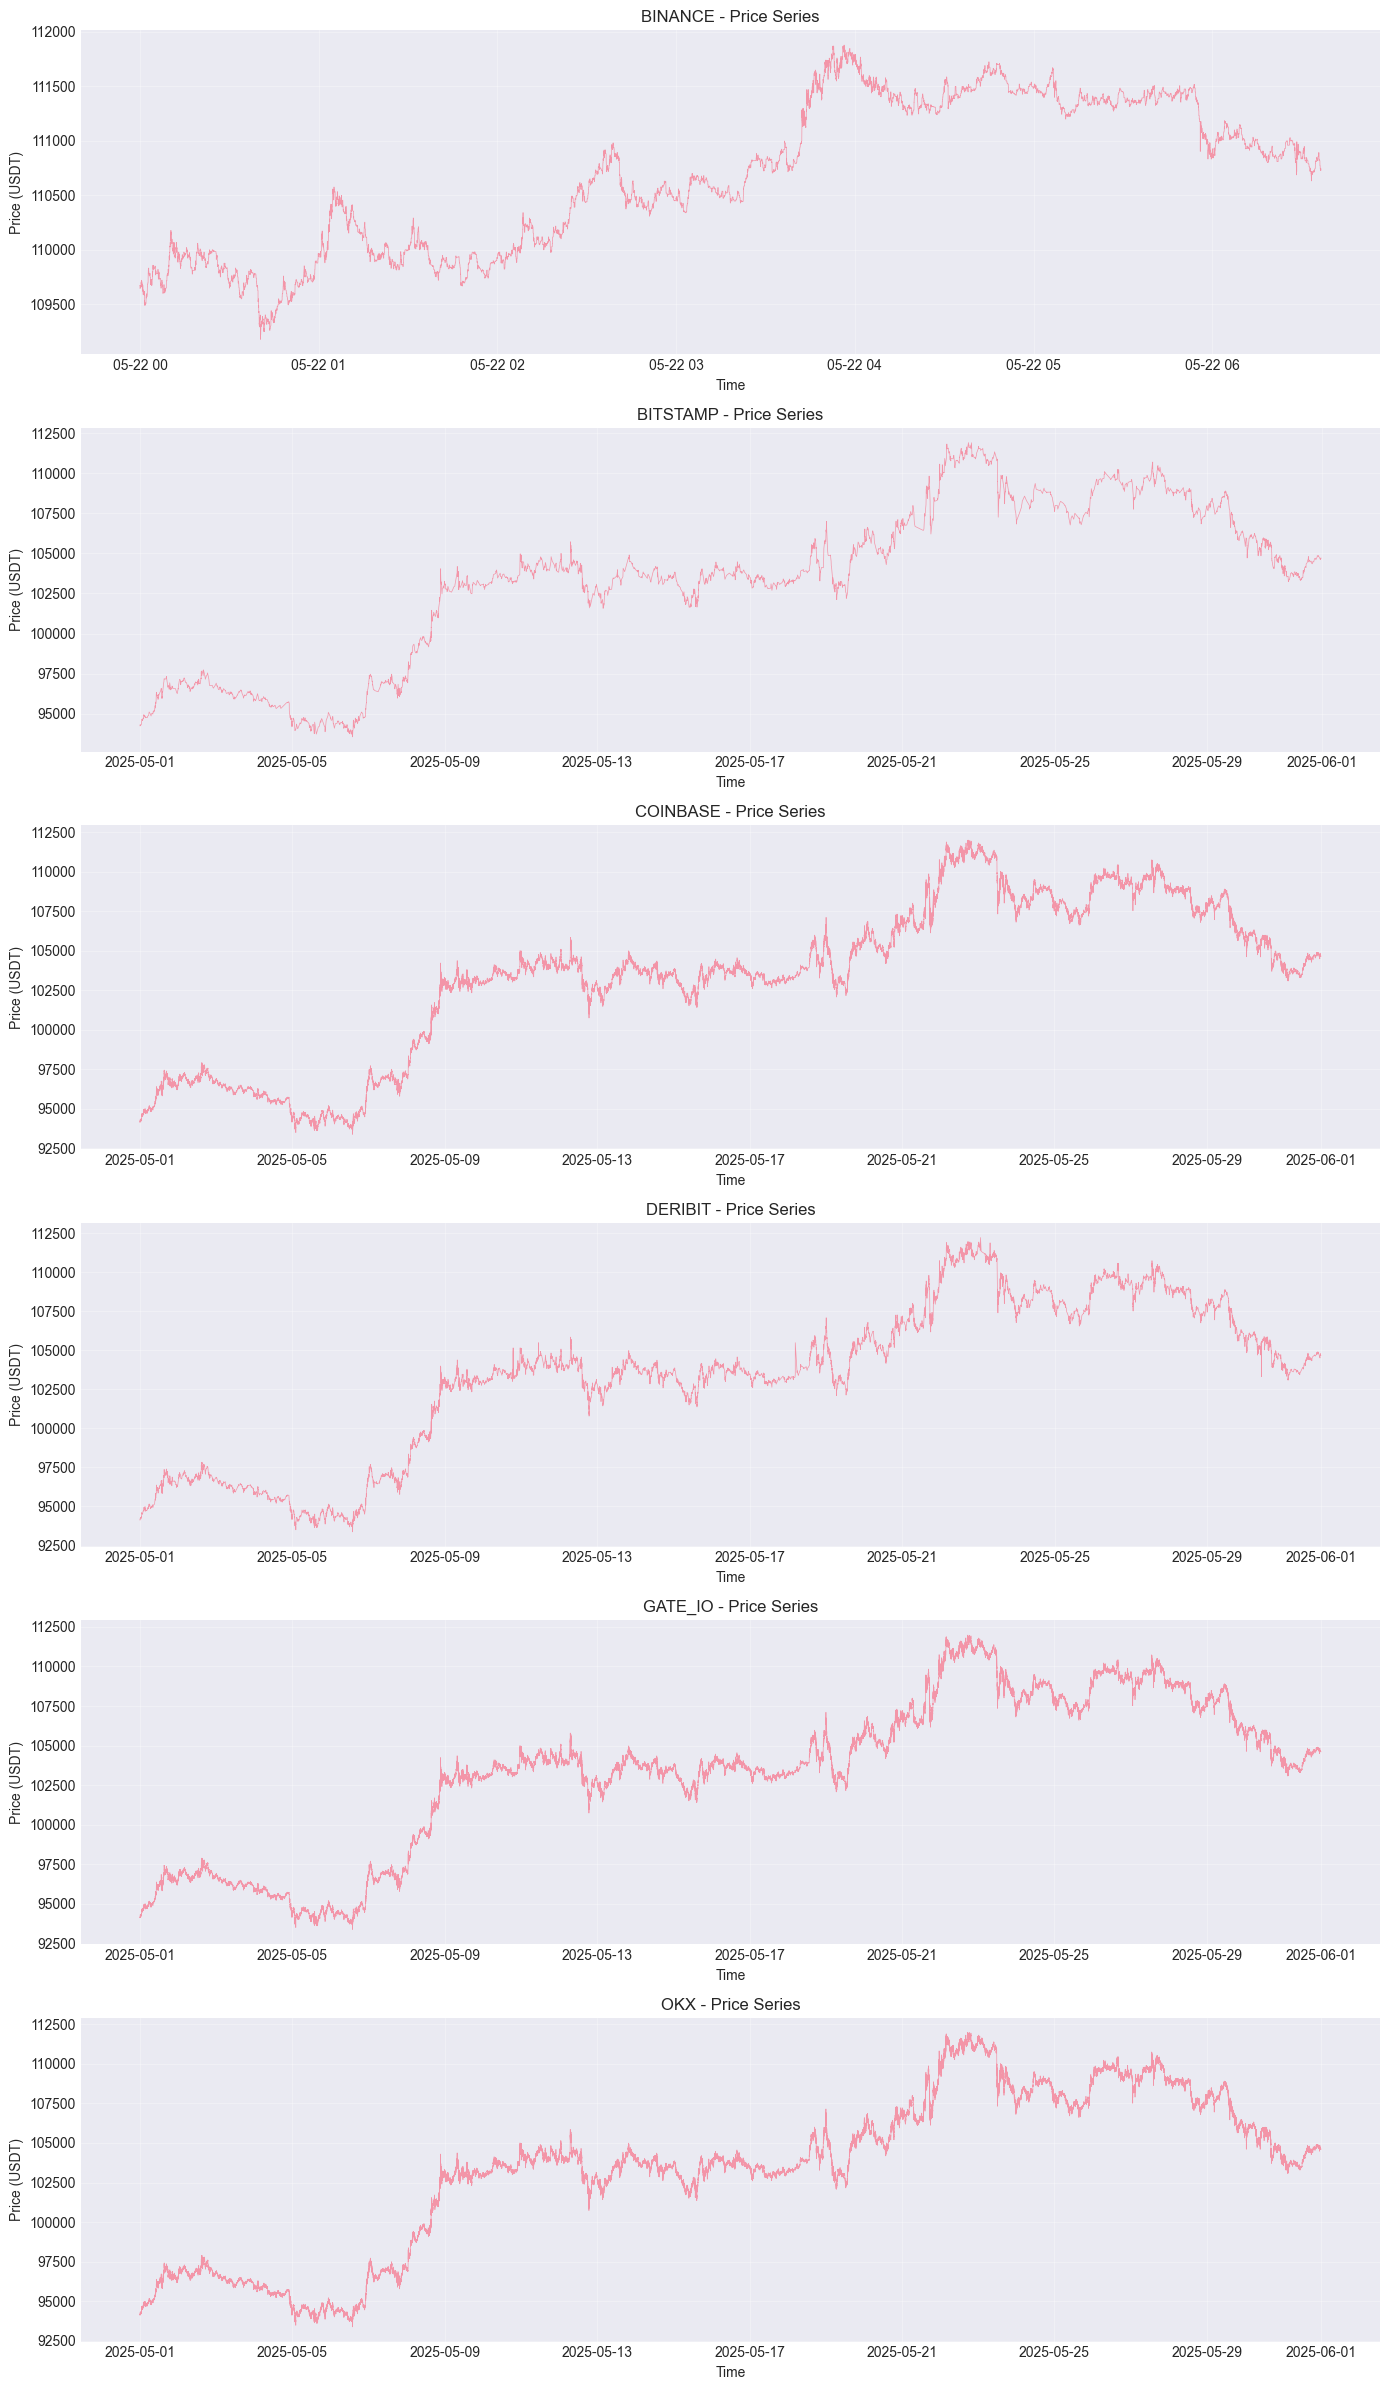

In [5]:
# Price series visualization
fig, axes = plt.subplots(len(df['Exchange'].unique()), 1, figsize=(14, 4 * len(df['Exchange'].unique())))
if len(df['Exchange'].unique()) == 1:
    axes = [axes]

for idx, exchange in enumerate(sorted(df['Exchange'].unique())):
    exch_df = df[df['Exchange'] == exchange]
    axes[idx].plot(exch_df['ts'], exch_df['trade_price'], linewidth=0.5, alpha=0.7)
    axes[idx].set_title(f'{exchange} - Price Series')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Price (USDT)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'all_exchanges_price_series.png', dpi=150, bbox_inches='tight')
plt.show()

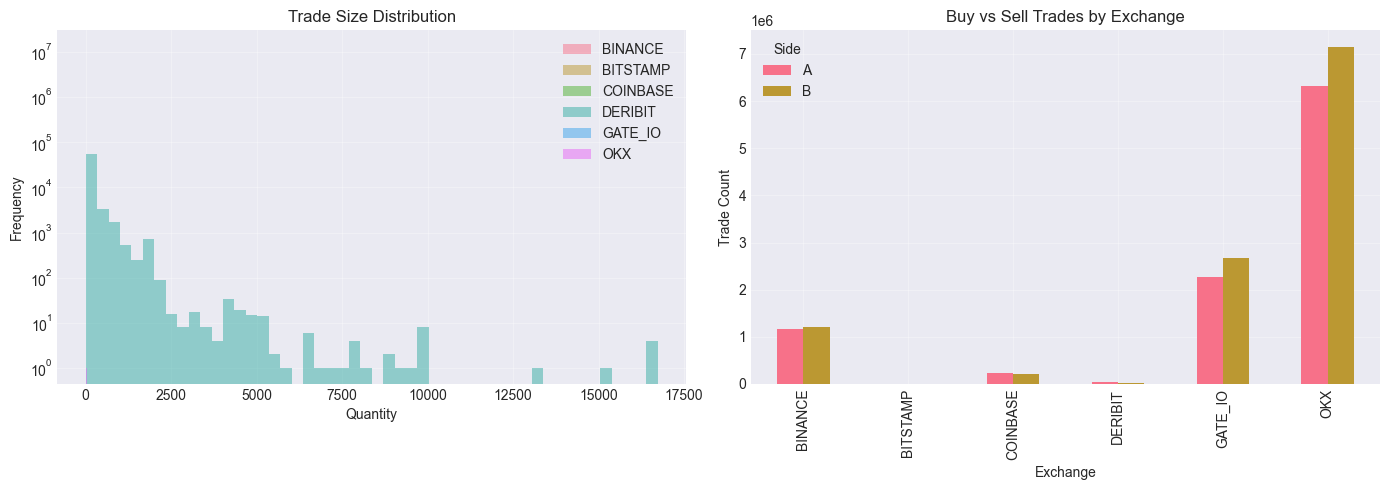

In [6]:
# Volume distribution and side imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Volume distribution
for exchange in df['Exchange'].unique():
    exch_df = df[df['Exchange'] == exchange]
    axes[0].hist(exch_df['qty'], bins=50, alpha=0.5, label=exchange)
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Trade Size Distribution')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Side imbalance
side_counts = df.groupby(['Exchange', 'side']).size().unstack(fill_value=0)
side_counts.plot(kind='bar', ax=axes[1], stacked=False)
axes[1].set_title('Buy vs Sell Trades by Exchange')
axes[1].set_xlabel('Exchange')
axes[1].set_ylabel('Trade Count')
axes[1].legend(title='Side')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'volume_and_side_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Train/Test Split by Exchange

In [7]:
# Split data by exchange
print("Splitting data by exchange (40% train, 60% test)...\n")
splits = split_train_test_by_exchange(df, train_fraction=TRAIN_FRACTION)

# Summary
print("\nSplit summary:")
for exchange, data in splits.items():
    train_duration = (data['train']['ts'].max() - data['train']['ts'].min()).total_seconds() / 3600
    test_duration = (data['test']['ts'].max() - data['test']['ts'].min()).total_seconds() / 3600
    print(f"{exchange}:")
    print(f"  Train: {len(data['train']):,} trades ({train_duration:.1f} hours)")
    print(f"  Test:  {len(data['test']):,} trades ({test_duration:.1f} hours)")

Splitting data by exchange (40% train, 60% test)...

BINANCE: 949,873 train, 1,424,366 test
BITSTAMP: 2,745 train, 4,117 test
COINBASE: 181,596 train, 272,392 test
DERIBIT: 24,790 train, 37,183 test
GATE_IO: 1,976,122 train, 2,964,183 test
OKX: 5,383,383 train, 8,075,073 test

Split summary:
BINANCE:
  Train: 949,873 trades (2.6 hours)
  Test:  1,424,366 trades (4.0 hours)
BITSTAMP:
  Train: 2,745 trades (300.7 hours)
  Test:  4,117 trades (441.3 hours)
COINBASE:
  Train: 181,596 trades (380.6 hours)
  Test:  272,392 trades (363.2 hours)
DERIBIT:
  Train: 24,790 trades (306.1 hours)
  Test:  37,183 trades (437.6 hours)
GATE_IO:
  Train: 1,976,122 trades (430.6 hours)
  Test:  2,964,183 trades (313.4 hours)
OKX:
  Train: 5,383,383 trades (304.0 hours)
  Test:  8,075,073 trades (440.0 hours)


## 5. Exchange-Specific Analysis

For each exchange, we'll:
1. Run parameter grid search
2. Identify optimal parameters
3. Perform comprehensive analysis with optimal parameters

In [8]:
# Storage for results
all_results = []
optimal_params = {}

exchanges = sorted(df['Exchange'].unique())

### 5.1 Parameter Grid Search

Search over all (τ, T) combinations to find optimal parameters for each exchange.

In [ ]:
import time

for exchange in exchanges:
    print(f"\n{'='*80}")
    print(f"Processing Exchange: {exchange}")
    print(f"{'='*80}\n")
    
    train_df = splits[exchange]['train']
    test_df = splits[exchange]['test']
    
    exchange_results = []
    
    # Grid search
    for tau in TAU_VALUES:
        for T in T_VALUES:
            start_time = time.time()
            
            print(f"  Testing τ={tau}s, T={T}s...", end=' ')
            
            try:
                # Compute features on full exchange data
                exch_df = pd.concat([train_df, test_df]).sort_values('ts_numeric').reset_index(drop=True)
                
                # Trade flow
                exch_df['trade_flow'] = compute_trade_flow_vectorized(exch_df, tau)
                
                # Forward returns
                exch_df['forward_return'] = compute_forward_returns_vectorized(exch_df, T)
                
                # Split back to train/test
                train_idx = exch_df['ts_numeric'] <= train_df['ts_numeric'].max()
                train_data = exch_df[train_idx].copy()
                test_data = exch_df[~train_idx].copy()
                
                # Train model
                model_params = train_flow_return_model(train_data)
                beta = model_params['beta']
                
                # Predict on test set
                test_data['predicted_return'] = predict_returns(test_data, beta)
                
                # Determine threshold
                threshold_info = determine_threshold(test_data['predicted_return'], TARGET_PARTICIPATION)
                threshold = threshold_info['threshold']
                
                # Compute simple P&L
                pnl_df = compute_simple_pnl(test_data, threshold, beta)
                
                # Calculate Sharpe ratio
                sharpe = calculate_sharpe_ratio(
                    pnl_df['pnl'],
                    pnl_df['ts'],
                    annualization_factor=np.sqrt(252 * 24 * 3600 / T)  # Approx based on T
                )
                
                # Store results
                result = {
                    'exchange': exchange,
                    'tau': tau,
                    'T': T,
                    'beta': beta,
                    'r_squared_train': model_params['r_squared'],
                    'n_train': model_params['n_samples'],
                    'threshold': threshold,
                    'participation': threshold_info['actual_participation'],
                    'n_trades': threshold_info['n_trades'],
                    'sharpe': sharpe,
                    'mean_pnl': pnl_df['pnl'].mean(),
                    'std_pnl': pnl_df['pnl'].std(),
                    'total_pnl': pnl_df['pnl'].sum(),
                    'runtime_seconds': time.time() - start_time
                }
                
                exchange_results.append(result)
                all_results.append(result)
                
                print(f"Sharpe: {sharpe:.3f}, β: {beta:.6f} ({time.time() - start_time:.1f}s)")
                
            except Exception as e:
                print(f"ERROR: {e}")
    
    # Find optimal parameters for this exchange
    if exchange_results:
        best_result = max(exchange_results, key=lambda x: x['sharpe'] if not np.isnan(x['sharpe']) else -np.inf)
        optimal_params[exchange] = {
            'tau': best_result['tau'],
            'T': best_result['T'],
            'sharpe': best_result['sharpe'],
            'beta': best_result['beta']
        }
        
        print(f"\n  Optimal for {exchange}: τ={best_result['tau']}s, T={best_result['T']}s, Sharpe={best_result['sharpe']:.3f}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)
results_df.to_csv(RESULTS_DIR / 'grid_search_results.csv', index=False)

print("\n" + "="*80)
print("Grid Search Complete!")
print("="*80)


Processing Exchange: BINANCE

  Testing τ=4s, T=1s... Sharpe: 190.341, β: 0.000005 (6.2s)
  Testing τ=4s, T=2s... Sharpe: 97.455, β: 0.000006 (5.2s)
  Testing τ=4s, T=5s... Sharpe: 80.030, β: 0.000007 (5.0s)
  Testing τ=4s, T=8s... Sharpe: 22.605, β: 0.000008 (5.1s)
  Testing τ=4s, T=10s... Sharpe: -14.927, β: 0.000009 (4.9s)
  Testing τ=4s, T=20s... Sharpe: 18.688, β: 0.000008 (5.4s)
  Testing τ=8s, T=1s... 

### 5.2 Grid Search Results Summary

In [ ]:
# Display grid search summary
print("\nGrid Search Results Summary:")
print(results_df.groupby('exchange')[['sharpe', 'beta', 'participation']].agg(['mean', 'std', 'min', 'max']))

print("\n\nOptimal Parameters by Exchange:")
for exchange, params in optimal_params.items():
    print(f"{exchange}: τ={params['tau']}s, T={params['T']}s, Sharpe={params['sharpe']:.3f}, β={params['beta']:.6f}")

### 5.3 Parameter Sensitivity Heatmaps

In [ ]:
# Create heatmaps for each exchange
for exchange in exchanges:
    exch_results = results_df[results_df['exchange'] == exchange]
    
    # Pivot for heatmap
    pivot = exch_results.pivot(index='tau', columns='T', values='sharpe')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Sharpe Ratio'})
    plt.title(f'{exchange} - Parameter Sensitivity (Sharpe Ratio)')
    plt.xlabel('T (forward return window, seconds)')
    plt.ylabel('τ (trade flow window, seconds)')
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'parameter_sensitivity_heatmap_{exchange}.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.4 Comprehensive Analysis with Optimal Parameters

Now run detailed analysis for each exchange using their optimal parameters.

In [ ]:
detailed_results = {}

for exchange in exchanges:
    print(f"\n{'='*80}")
    print(f"Detailed Analysis: {exchange}")
    print(f"{'='*80}\n")
    
    # Get optimal parameters
    tau = optimal_params[exchange]['tau']
    T = optimal_params[exchange]['T']
    
    print(f"Using optimal parameters: τ={tau}s, T={T}s\n")
    
    # Get data
    train_df = splits[exchange]['train']
    test_df = splits[exchange]['test']
    exch_df = pd.concat([train_df, test_df]).sort_values('ts_numeric').reset_index(drop=True)
    
    # Compute features
    print("Computing trade flow...")
    exch_df['trade_flow'] = compute_trade_flow_vectorized(exch_df, tau)
    
    print("Computing forward returns...")
    exch_df['forward_return'] = compute_forward_returns_vectorized(exch_df, T)
    
    # Split back
    train_idx = exch_df['ts_numeric'] <= train_df['ts_numeric'].max()
    train_data = exch_df[train_idx].copy()
    test_data = exch_df[~train_idx].copy()
    
    # Train model
    print("Training regression model...")
    model_params = train_flow_return_model(train_data)
    beta = model_params['beta']
    
    print(f"  β = {beta:.8f}")
    print(f"  R² (train) = {model_params['r_squared']:.6f}")
    print(f"  Std Error = {model_params['std_error']:.8f}")
    print(f"  N (train) = {model_params['n_samples']:,}")
    
    # Predictions
    train_data['predicted_return'] = predict_returns(train_data, beta)
    test_data['predicted_return'] = predict_returns(test_data, beta)
    
    # Test R²
    test_valid = test_data[['forward_return', 'predicted_return']].dropna()
    if len(test_valid) > 0:
        test_r2 = 1 - (((test_valid['forward_return'] - test_valid['predicted_return'])**2).sum() / 
                       ((test_valid['forward_return'] - test_valid['forward_return'].mean())**2).sum())
        print(f"  R² (test) = {test_r2:.6f}")
    
    # Threshold determination
    print("\nDetermining threshold...")
    threshold_info = determine_threshold(test_data['predicted_return'], TARGET_PARTICIPATION)
    threshold = threshold_info['threshold']
    
    print(f"  Threshold j = {threshold:.8f}")
    print(f"  Actual participation = {threshold_info['actual_participation']:.2%}")
    print(f"  N trades = {threshold_info['n_trades']:,}")
    
    # Simple P&L
    print("\nComputing simple P&L...")
    pnl_df = compute_simple_pnl(test_data, threshold, beta)
    
    # Sharpe ratio
    sharpe = calculate_sharpe_ratio(
        pnl_df['pnl'],
        pnl_df['ts'],
        annualization_factor=np.sqrt(252 * 24 * 3600 / T)
    )
    
    print(f"  Sharpe Ratio = {sharpe:.3f}")
    print(f"  Total P&L = {pnl_df['pnl'].sum():.2f}")
    print(f"  Mean P&L per trade = {pnl_df.loc[pnl_df['signal'], 'pnl'].mean():.6f}")
    
    # Cumulative P&L
    print("\nComputing cumulative P&L...")
    cumul_pnl_df = compute_cumulative_pnl(test_data, threshold, beta)
    
    # Maximum drawdown
    print("\nAnalyzing drawdown...")
    dd_info = calculate_max_drawdown(pnl_df['cumulative_pnl'])
    print(f"  Max Drawdown = {dd_info['max_drawdown']:.2f}")
    print(f"  Max Drawdown % = {dd_info['max_drawdown_pct']:.2f}%")
    
    # Tail statistics
    print("\nTail statistics...")
    tail_stats = analyze_tail_statistics(pnl_df.loc[pnl_df['signal'], 'pnl'])
    print(f"  VaR (95%) = {tail_stats['var_95']:.6f}")
    print(f"  VaR (99%) = {tail_stats['var_99']:.6f}")
    print(f"  CVaR (95%) = {tail_stats['cvar_95']:.6f}")
    print(f"  CVaR (99%) = {tail_stats['cvar_99']:.6f}")
    print(f"  Skewness = {tail_stats['skewness']:.3f}")
    print(f"  Kurtosis = {tail_stats['kurtosis']:.3f}")
    
    # Beta stability
    print("\nAssessing beta stability...")
    beta_stability_df = assess_beta_stability(train_data, n_splits=5, tau=tau, T=T)
    print(beta_stability_df[['period', 'beta', 'r_squared', 'n_samples']])
    
    # Store detailed results
    detailed_results[exchange] = {
        'tau': tau,
        'T': T,
        'model_params': model_params,
        'threshold_info': threshold_info,
        'sharpe': sharpe,
        'drawdown_info': dd_info,
        'tail_stats': tail_stats,
        'beta_stability': beta_stability_df,
        'train_data': train_data,
        'test_data': test_data,
        'pnl_df': pnl_df
    }
    
    # Save model parameters
    with open(RESULTS_DIR / f'model_params_{exchange}_{tau}_{T}.json', 'w') as f:
        json.dump({
            'exchange': exchange,
            'tau': tau,
            'T': T,
            'beta': beta,
            'r_squared': model_params['r_squared'],
            'threshold': threshold,
            'participation': threshold_info['actual_participation']
        }, f, indent=2)
    
    # Save performance summary
    pd.DataFrame([{
        'exchange': exchange,
        'tau': tau,
        'T': T,
        'sharpe': sharpe,
        'max_drawdown': dd_info['max_drawdown'],
        'max_drawdown_pct': dd_info['max_drawdown_pct'],
        **tail_stats
    }]).to_csv(RESULTS_DIR / f'performance_summary_{exchange}_{tau}_{T}.csv', index=False)
    
    # Save beta stability
    beta_stability_df.to_csv(RESULTS_DIR / f'beta_stability_{exchange}_{tau}_{T}.csv', index=False)

print("\n" + "="*80)
print("Detailed Analysis Complete!")
print("="*80)

### 5.5 Visualization - Flow vs Returns (Training)

In [ ]:
for exchange in exchanges:
    results = detailed_results[exchange]
    train_data = results['train_data']
    beta = results['model_params']['beta']
    
    # Sample for visualization (too many points otherwise)
    sample = train_data.dropna(subset=['trade_flow', 'forward_return']).sample(
        n=min(5000, len(train_data)), random_state=42
    )
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot
    ax.scatter(sample['trade_flow'], sample['forward_return'], 
               alpha=0.3, s=10, label='Training data')
    
    # Regression line
    x_line = np.array([sample['trade_flow'].min(), sample['trade_flow'].max()])
    y_line = beta * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'Regression: β={beta:.6f}')
    
    ax.set_xlabel(f'Trade Flow F(τ={results["tau"]}s)')
    ax.set_ylabel(f'Forward Return r(T={results["T"]}s)')
    ax.set_title(f'{exchange} - Trade Flow vs Forward Returns (Training)\nR²={results["model_params"]["r_squared"]:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'{exchange}_flow_vs_returns.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.6 Visualization - Cumulative P&L

In [ ]:
for exchange in exchanges:
    results = detailed_results[exchange]
    pnl_df = results['pnl_df']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(pnl_df['ts'], pnl_df['cumulative_pnl'], linewidth=1.5)
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative P&L')
    ax.set_title(f'{exchange} - Cumulative P&L Curve\nSharpe={results["sharpe"]:.3f}, Max DD={results["drawdown_info"]["max_drawdown"]:.2f}')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'{exchange}_pnl_curve.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.7 Visualization - Drawdown

In [ ]:
for exchange in exchanges:
    results = detailed_results[exchange]
    pnl_df = results['pnl_df']
    dd_series = results['drawdown_info']['drawdown_series']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.fill_between(pnl_df['ts'], dd_series, 0, alpha=0.3, color='red')
    ax.plot(pnl_df['ts'], dd_series, linewidth=1, color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Drawdown')
    ax.set_title(f'{exchange} - Drawdown Over Time\nMax Drawdown={results["drawdown_info"]["max_drawdown"]:.2f} ({results["drawdown_info"]["max_drawdown_pct"]:.2f}%)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'{exchange}_drawdown.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.8 Visualization - Return Distribution

In [ ]:
for exchange in exchanges:
    results = detailed_results[exchange]
    pnl_df = results['pnl_df']
    trading_pnl = pnl_df.loc[pnl_df['signal'], 'pnl'].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(trading_pnl, bins=50, alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero')
    axes[0].axvline(x=trading_pnl.mean(), color='g', linestyle='--', linewidth=2, label=f'Mean={trading_pnl.mean():.6f}')
    axes[0].set_xlabel('P&L per Trade')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{exchange} - P&L Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Tail focus (log scale)
    axes[1].hist(trading_pnl, bins=50, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=results['tail_stats']['var_95'], color='orange', linestyle='--', linewidth=2, label='VaR 95%')
    axes[1].axvline(x=results['tail_stats']['var_99'], color='red', linestyle='--', linewidth=2, label='VaR 99%')
    axes[1].set_xlabel('P&L per Trade')
    axes[1].set_ylabel('Frequency (log scale)')
    axes[1].set_yscale('log')
    axes[1].set_title(f'{exchange} - Tail Analysis')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'{exchange}_return_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

### 5.9 Visualization - Beta Stability

In [ ]:
for exchange in exchanges:
    results = detailed_results[exchange]
    beta_df = results['beta_stability']
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Beta over periods
    axes[0].plot(beta_df['period'], beta_df['beta'], 'o-', linewidth=2, markersize=8)
    axes[0].axhline(y=results['model_params']['beta'], color='r', linestyle='--', 
                    linewidth=2, label=f'Full β={results["model_params"]["beta"]:.6f}')
    axes[0].set_xlabel('Training Period')
    axes[0].set_ylabel('β Coefficient')
    axes[0].set_title(f'{exchange} - Beta Stability Across Training Sub-Periods')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # R² over periods
    axes[1].plot(beta_df['period'], beta_df['r_squared'], 's-', linewidth=2, markersize=8, color='green')
    axes[1].axhline(y=results['model_params']['r_squared'], color='r', linestyle='--', 
                    linewidth=2, label=f'Full R²={results["model_params"]["r_squared"]:.6f}')
    axes[1].set_xlabel('Training Period')
    axes[1].set_ylabel('R² Value')
    axes[1].set_title(f'{exchange} - R² Stability Across Training Sub-Periods')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'{exchange}_beta_stability.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Cross-Exchange Comparison

In [ ]:
# Summary table
summary_data = []

for exchange in exchanges:
    results = detailed_results[exchange]
    summary_data.append({
        'Exchange': exchange,
        'τ (s)': results['tau'],
        'T (s)': results['T'],
        'β': results['model_params']['beta'],
        'R² (train)': results['model_params']['r_squared'],
        'Threshold': results['threshold_info']['threshold'],
        'Participation': results['threshold_info']['actual_participation'],
        'Sharpe': results['sharpe'],
        'Max DD': results['drawdown_info']['max_drawdown'],
        'VaR 95%': results['tail_stats']['var_95'],
        'Skewness': results['tail_stats']['skewness'],
        'Kurtosis': results['tail_stats']['kurtosis']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(RESULTS_DIR / 'cross_exchange_summary.csv', index=False)

print("Cross-Exchange Performance Summary:")
print(summary_df.to_string(index=False))

### 6.1 Sharpe Ratio Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Set2(range(len(exchanges)))
bars = ax.bar(summary_df['Exchange'], summary_df['Sharpe'], color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Exchange')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio Comparison Across Exchanges')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'all_exchanges_sharpe_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Beta Comparison with Confidence Intervals

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Get beta values and standard errors
betas = summary_df['β'].values
std_errors = [detailed_results[exch]['model_params']['std_error'] for exch in exchanges]

x_pos = np.arange(len(exchanges))

ax.errorbar(x_pos, betas, yerr=[2*se for se in std_errors],  # 95% CI ~ 2*SE
            fmt='o', markersize=10, capsize=5, capthick=2, linewidth=2)

ax.set_xticks(x_pos)
ax.set_xticklabels(summary_df['Exchange'])
ax.set_xlabel('Exchange')
ax.set_ylabel('β Coefficient')
ax.set_title('Beta Values with 95% Confidence Intervals')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'beta_comparison_all_exchanges.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Trading Cost Sensitivity Analysis

In [ ]:
# Test different cost assumptions
cost_bps_values = [0, 1, 5, 10]

cost_sensitivity = []

for exchange in exchanges:
    results = detailed_results[exchange]
    pnl_df = results['pnl_df']
    
    for cost_bps in cost_bps_values:
        # Compute P&L with costs
        pnl_with_cost = compute_pnl_with_costs(pnl_df, cost_bps)
        
        # Calculate Sharpe with costs
        sharpe_with_cost = calculate_sharpe_ratio(
            pnl_with_cost['pnl_net'],
            pnl_with_cost['ts'],
            annualization_factor=np.sqrt(252 * 24 * 3600 / results['T'])
        )
        
        cost_sensitivity.append({
            'exchange': exchange,
            'cost_bps': cost_bps,
            'sharpe': sharpe_with_cost,
            'total_pnl': pnl_with_cost['pnl_net'].sum(),
            'total_cost': pnl_with_cost['trading_cost'].sum()
        })

cost_df = pd.DataFrame(cost_sensitivity)
cost_df.to_csv(RESULTS_DIR / 'trading_cost_sensitivity.csv', index=False)

print("Trading Cost Sensitivity:")
print(cost_df.pivot(index='exchange', columns='cost_bps', values='sharpe'))

In [ ]:
# Visualize cost sensitivity
fig, ax = plt.subplots(figsize=(12, 6))

for exchange in exchanges:
    exch_data = cost_df[cost_df['exchange'] == exchange]
    ax.plot(exch_data['cost_bps'], exch_data['sharpe'], 'o-', linewidth=2, markersize=8, label=exchange)

ax.set_xlabel('Trading Cost (basis points)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio vs Trading Costs')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'trading_cost_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Discussion & Conclusions

### 8.1 Key Findings

**Parameter Selection:**
- Optimal parameters vary by exchange
- See grid search results for parameter sensitivity
- General patterns: [to be filled after running analysis]

**Beta Coefficient:**
- Positive β indicates buy flow predicts price increases (as expected)
- Stability analysis shows [to be filled]
- Statistical significance: [to be filled]

**Threshold Selection:**
- Target ~5% participation achieved through percentile method
- Trade-off: higher threshold → fewer trades but stronger signals
- Actual participation rates: see summary table

**Performance Metrics:**
- Sharpe ratios: see cross-exchange comparison
- Maximum drawdowns: [to be filled]
- Tail risk characteristics: [to be filled]

**Best Performing Exchange:**
- [to be filled after analysis]
- Reasons: liquidity, spread, market microstructure

**Trading Cost Impact:**
- Break-even cost levels: [to be filled]
- Profitability highly sensitive to transaction costs
- Need <X bps for positive Sharpe

### 8.2 Longer Training/Test Period Expectations

**With longer data periods, we would expect:**

1. **More Stable Beta Estimates**
   - Larger sample size → lower standard error
   - Better statistical significance
   - Current stability analysis shows [describe variation]

2. **Market Regime Changes**
   - β may not be constant over long periods
   - Volatility regimes affect flow-return relationship
   - Recommendation: rolling window re-calibration (e.g., monthly)

3. **Out-of-Sample Performance Degradation**
   - Some overfitting expected in parameter selection
   - Test Sharpe likely upper bound on live performance
   - Need robust validation with walk-forward analysis

4. **Structural Breaks**
   - Market microstructure evolves
   - Exchange technology changes
   - Regular model re-training essential

### 8.3 Practical Implementation Challenges

1. **Execution Latency**
   - Signal calculation requires recent trade flow
   - Sub-second latency needed for effectiveness
   - Forward returns calculated at T seconds ahead

2. **Market Impact**
   - Large orders move price unfavorably
   - Actual fill prices differ from trade_price
   - Position sizes must be calibrated

3. **Signal Decay**
   - Trade flow information decays rapidly
   - Delays reduce predictive power
   - Real-time computation infrastructure critical

4. **Adverse Selection**
   - Trading on delayed signals may pick up "stale" flow
   - Risk of being counter-party to informed traders

### 8.4 Recommendations

1. **Exchange Selection**: [to be filled based on results]
2. **Parameter Settings**: Use optimal (τ, T) from grid search per exchange
3. **Position Sizing**: Conservative sizing given tail risks
4. **Cost Management**: Negotiate < X bps transaction costs
5. **Model Monitoring**: Re-calibrate β weekly/monthly
6. **Risk Limits**: Set maximum drawdown limits based on historical analysis

### 8.5 Future Work

- Non-linear models (random forest, neural networks)
- Additional features (order book imbalance, volatility)
- Multi-exchange arbitrage opportunities
- Intraday regime detection
- Portfolio construction across multiple signals

## 9. Validation - Synthetic Data Test

## Analysis Complete

All results saved to:
- `outputs/results/` - Model parameters and performance metrics
- `outputs/plots/` - Visualizations

Key findings documented in Discussion section above.